In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from unidecode import unidecode
import requests
import json

In [12]:
edges = pd.read_csv('data/edges.csv')
ror_names = pd.read_parquet('data/new_edges.parquet')
ror_names = ror_names[['std_institution', 'institution']]
edges = edges.merge(ror_names, on='institution', how='left')
# grafo = gpd.read_file('data/grafo.gdf')
# edges = pd.DataFrame(grafo)
# edges

In [13]:
def query_ror(name):
    query_name = unidecode(name).replace(' ', '%20')
    query_str = f'https://api.ror.org/organizations?query.advanced=name:{query_name}'
    results = requests.get(query_str)
    std_name = json.loads(results.text)
    if len(std_name['items']) == 0:
        return name
    return std_name['items'][0]['name']

In [14]:
# edges['std_institution'] = edges.institution.map(query_ror)

In [22]:
edges[edges.institution == 'universidade federal de são carlos'][['intitution','std_institution']]

,source_id_lattes,target_id_lattes,academic_degree,start_year,conclusion_year,course,institution,thesis,major_area,area,std_institution
29,6167735734348703,174385402367,pos-doutorado,NaN,2021,NaN,universidade federal de são carlos,NaN,NaN,NaN,universidade federal de são carlos
30,7070885875161111,174385402367,mestrado,2013.0,2015,engenharia química,universidade federal de são carlos,desenvolvimento de um secador tipo cesto rotat...,NaN,NaN,universidade federal de são carlos
31,9933650905615452,174385402367,doutorado,2015.0,2019,engenharia química,universidade federal de são carlos,avaliação de adsorventes obtidos a partir de r...,NaN,NaN,universidade federal de são carlos
265,793038362058,194644249955417,doutorado,2013.0,2016,engenharia de produção,universidade federal de são carlos,emergência e dinâmicas das práticas de recicla...,engenharias,NaN,universidade federal de são carlos
266,793038362058,360393792578550,doutorado,2016.0,2020,engenharia de produção,universidade federal de são carlos,compromissos e disputas entre domesticidade e ...,ciencias humanas,NaN,universidade federal de são carlos
...,...,...,...,...,...,...,...,...,...,...,...
1632879,9911833172043700,9813988620236704,mestrado,2016.0,2019,ciências ambientais,universidade federal de são carlos,mapeamento dos conflitos ambientais e urbaníst...,ciencias sociais aplicadas,NaN,universidade federal de são carlos
1632927,9826026025118073,9893034966040171,mestrado,2011.0,2013,ciência da computação,universidade federal de são carlos,algoritmo para a extração incremental de sequê...,ciencias exatas e da terra,NaN,universidade federal de são carlos
1633001,9848311210578810,9954252416721535,mestrado,1993.0,1997,ciência e engenharia dos materiais,universidade federal de são carlos,mecanismo de corrossão de refratários do siste...,engenharias,NaN,universidade federal de são carlos
1633059,9868595523538592,9926751005913223,doutorado,2012.0,2016,psicologia,universidade federal de são carlos,construção e análise psicométrica de um invent...,ciencias humanas,NaN,universidade federal de são carlos


In [16]:
# edges.to_parquet('data/new_edges.parquet')

In [17]:
# edges.groupby('std_institution').count().reset_index()

In [18]:
def get_influence(edges, **features):
    output = {}
    for value, key in features.items():
        docs = edges[
            (edges[key] == value)
            & (edges.academic_degree == 'doutorado')
        ][['source_id_lattes', 'target_id_lattes', key, 'conclusion_year']]
        docs['gen'] = 0
        cols = [f'{key}_source', f'{key}_target',
                'conclusion_year_source', 'conclusion_year_target',
                'target_id_lattes', 'gen']
        gen = edges.set_index('target_id_lattes').join(
            docs.set_index('source_id_lattes'), how='inner', lsuffix='_source', rsuffix='_target'
        )[cols]
        docs = docs.set_index('target_id_lattes').drop(
            columns='source_id_lattes')
        while len(docs.index) > 0:
            new_gen = edges.set_index('source_id_lattes').join(
                docs, how='inner', lsuffix='_target', rsuffix='_source'
            )
            new_gen = new_gen[new_gen.academic_degree == 'doutorado']
            new_gen.gen += 1
            gen = pd.concat([gen, new_gen[cols]])
            docs = new_gen.copy().set_index('target_id_lattes')[
                [f'{key}_target', 'conclusion_year_target', 'gen']]
            docs.rename(columns={
                f'{key}_target': key,
                'conclusion_year_target': 'conclusion_year'
            }, inplace=True)

        output[f'{key}-{value}'] = gen.reset_index().rename(
            columns={'index': 'source_id_lattes'})
    return output


Index(['source_id_lattes', 'institution_target', 'conclusion_year_source',
       'conclusion_year_target', 'target_id_lattes', 'gen'],
      dtype='object')
Index(['porc', 'institution_target', 'conclusion_year_source',
       'conclusion_year_target', 'target_id_lattes', 'gen'],
      dtype='object')
        source_id_lattes                         institution_source  \
0          1493242282065                  universidade de são paulo   
1          1493242282065                  universidade de são paulo   
2          1493242282065                  universidade de são paulo   
3          1493242282065                  universidade de são paulo   
4          1493242282065                  universidade de são paulo   
...                  ...                                        ...   
288435  8210720478248773  universidade federal do rio grande do sul   
288436  8210720478248773  universidade federal do rio grande do sul   
288437  8329710538497873  universidade federal do rio gra

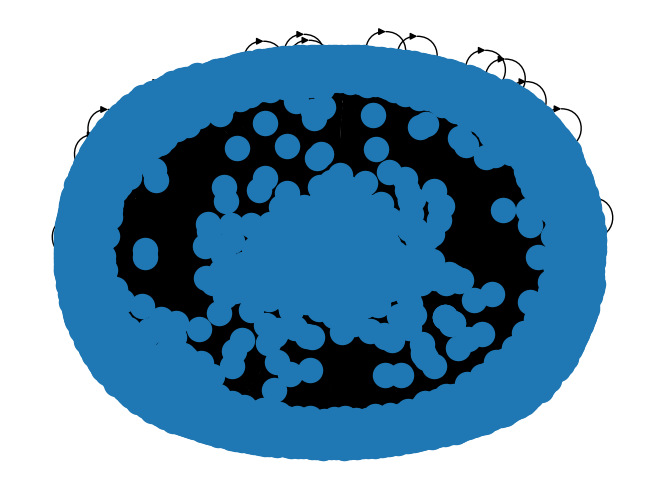

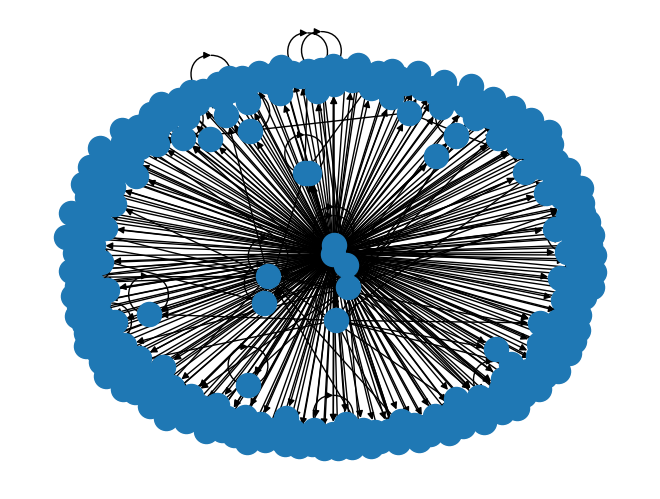

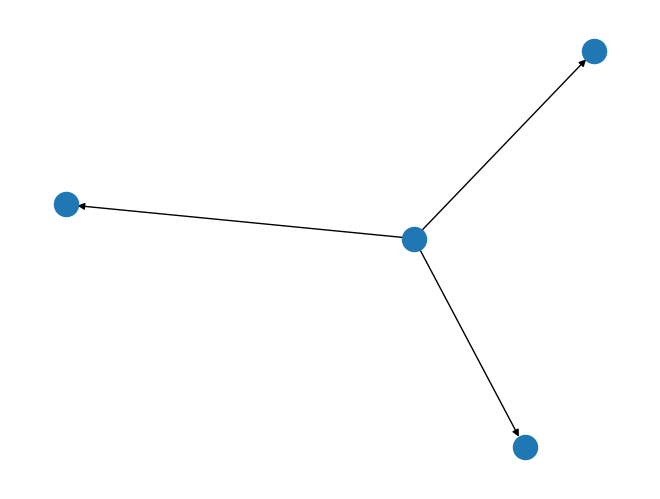

In [19]:
in_dict = {
    'universidade de são paulo': 'institution',
    'universidade federal de são carlos': 'institution',
    'universidade federal do abc': 'institution'
}
key = 'institution'
out_dict = get_influence(edges, **in_dict)
for key, value in out_dict.items():
    df = out_dict[key]
    size = df[df.gen == 0].shape[0]
    perc = df[df.gen == 0].groupby('institution_source').count()
    tot = round(100 * perc.rename(columns={'source_id_lattes': 'porc'})/size, 5)
    tot.sort_values('porc').to_csv(f'output/{key}-porc.csv')
    graph = df[df.gen > 0].groupby(['institution_source', 'institution_target']).agg(
        {'source_id_lattes': 'nunique',
         'target_id_lattes': 'count'
         })
    graph = graph.reset_index()
    graph.rename(columns={
        'source_id_lattes': 'seeds',
        'target_id_lattes': 'weight',
        'institution_source': 'source',
        'institution_target': 'target'
    }, inplace=True)
    graph['rate'] = graph.seeds / graph.weight 
    graph = graph.sort_values('rate')
    graph.to_csv(f'output/{key}-agrupado.csv')
    df.to_csv(f'output/{key}-bruto.csv')
    graph_ = nx.from_pandas_edgelist(
        graph,
        edge_attr='weight',
        create_using=nx.DiGraph
    )
    nx.write_graphml(graph_, f'output/{key}.graphml')
    plt.figure(key)
    nx.draw(graph_)
    plt.savefig(f'output/{key}.png')
    print(df)
    print(graph)


     source_id_lattes                             std_institution_source  \
0      58167334307476  Hospital das Clínicas da Faculdade de Medicina...   
1      58167334307476  Hospital das Clínicas da Faculdade de Medicina...   
2     203395024425799  Hospital das Clínicas da Faculdade de Medicina...   
3     203395024425799  Hospital das Clínicas da Faculdade de Medicina...   
4     387536243370151  Hospital das Clínicas da Faculdade de Medicina...   
..                ...                                                ...   
591  2679480309784746                  Universidade Estadual de Campinas   
592  2679480309784746                  Universidade Estadual de Campinas   
593  3279808920435051                  Universidade Estadual de Campinas   
594  3279808920435051                  Universidade Estadual de Campinas   
595  3574246433641347            faculdade de medicina de ribeirão preto   

                          std_institution_target  conclusion_year_source  \
0          

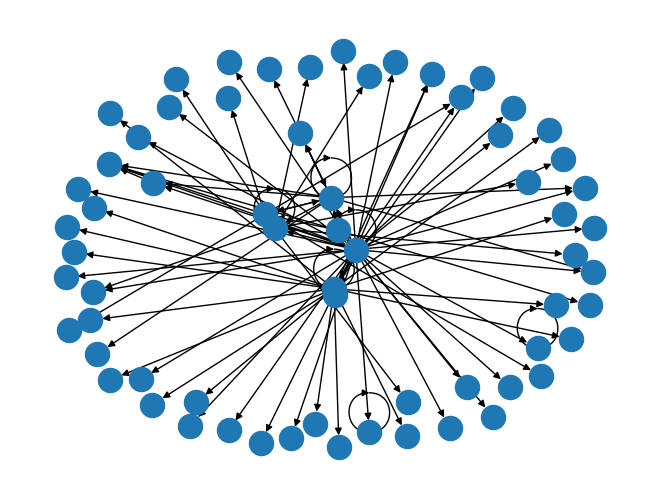

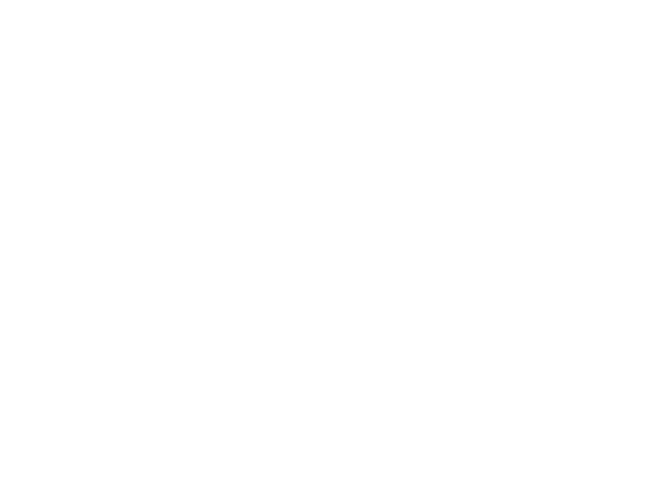

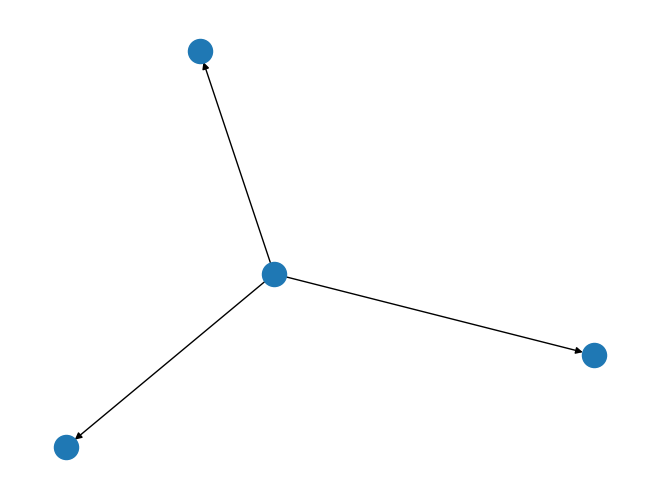

In [21]:
in_dict = {
    'Universidade de São Paulo': 'std_institution',
    'Universidade Federal de São Carlos': 'std_institution',
    'Universidade Federal do ABC': 'std_institution'
}
key = 'std_institution'
out_dict = get_influence(edges, **in_dict)
for key, value in out_dict.items():
    df = out_dict[key]
    size = df[df.gen == 0].shape[0]
    perc = df[df.gen == 0].groupby('std_institution_source').count()
    tot = round(100 * perc.rename(columns={'source_id_lattes': 'porc'})/size, 5)
    tot.sort_values('porc').to_csv(f'output/{key}-porc.csv')
    graph = df[df.gen > 0].groupby(['std_institution_source', 'std_institution_target']).agg(
        {'source_id_lattes': 'nunique',
         'target_id_lattes': 'count'
         })
    graph = graph.reset_index()
    graph.rename(columns={
        'source_id_lattes': 'seeds',
        'target_id_lattes': 'weight',
        'std_institution_source': 'source',
        'std_institution_target': 'target'
    }, inplace=True)
    graph['rate'] = graph.seeds / graph.weight 
    graph = graph.sort_values('rate')
    graph.to_csv(f'output/{key}-agrupado.csv')
    df.to_csv(f'output/{key}-bruto.csv')
    graph_ = nx.from_pandas_edgelist(
        graph,
        edge_attr='weight',
        create_using=nx.DiGraph
    )
    nx.write_graphml(graph_, f'output/{key}.graphml')
    plt.figure(key)
    nx.draw(graph_)
    plt.savefig(f'output/{key}.png')
    print(df)
    print(graph)
